# Landsat LAI Example - Static

In [1]:
import pprint

import ee
from IPython.display import Image

import openet.lai.landsat

ee.Initialize(use_cloud_api=True)


In [2]:
viridis_palette = ['#440154', '#433982', '#30678D', '#218F8B', '#36B677', '#8ED542', '#FDE725']
ndvi_palette = ['EFE7E1', '003300']

image_size = 768


In [3]:
# landsat_id = 'LC08_044033_20170918'  # Cloudy, some clear areas over northern CV
landsat_id = 'LC08_042034_20180705'  # Clear
landsat_sr_img = ee.Image('LANDSAT/LC08/C01/T1_SR/{}'.format(landsat_id))
landsat_crs = landsat_sr_img.select('B3').projection().getInfo()['crs']

In [4]:
site_xy = [-120.105, 36.95]
# site_xy = [-120.10237, 36.946608]
dx = 0.02
dy = 0.01
# dx = 0.012
# dy = 0.006
study_geom = ee.Geometry.Rectangle(site_xy[0]-dx, site_xy[1]-dy, site_xy[0]+dx, site_xy[1]+dy)
study_region = study_geom.bounds(1, 'EPSG:4326')


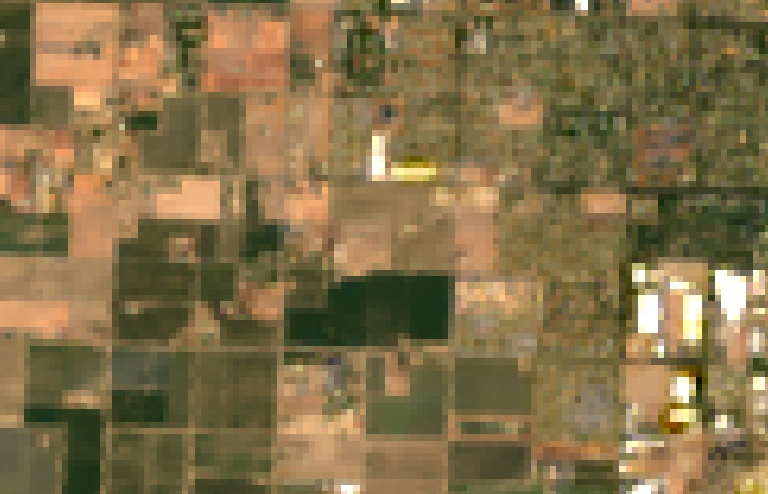

In [5]:
image_url = landsat_sr_img.select([3, 2, 1])\
    .getThumbURL({'min': 0.0, 'max': 3000, 
                  'dimensions':image_size, 'region': study_region})
Image(url=image_url, embed=True, format='png')


## Prepare the Landsat image for computing LAI

This primarily consists of standardizing the band names.

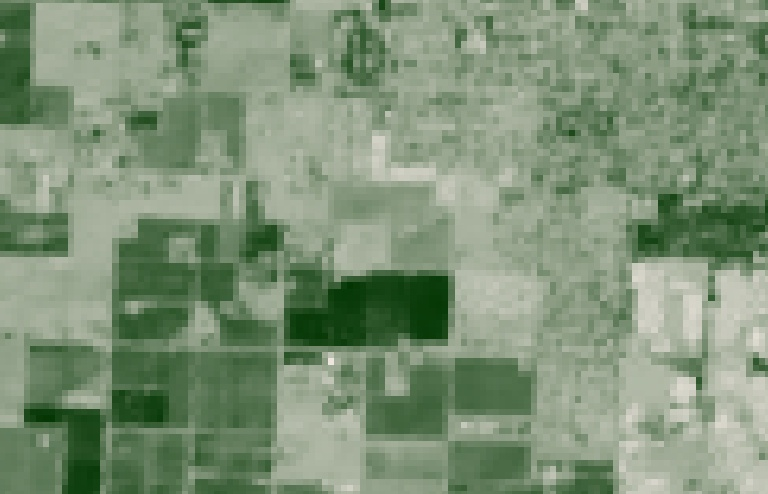

In [6]:
# Copied from PTJPL Image.from_landsat_c1_sr()
# CGM - The "SATELLITE" property must be set on the image for the algorithm to work
input_bands = ee.Dictionary({
    'LANDSAT_5': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'B6', 'pixel_qa'],
    'LANDSAT_7': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'B6', 'pixel_qa'],
    'LANDSAT_8': ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'pixel_qa']})
output_bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'tir', 'pixel_qa']
spacecraft_id = ee.String(landsat_sr_img.get('SATELLITE'))
prep_img = landsat_sr_img \
    .select(input_bands.get(spacecraft_id), output_bands) \
    .multiply([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.1, 1]) \
    .set({'system:index': landsat_sr_img.get('system:index'),
          'system:time_start': landsat_sr_img.get('system:time_start'),
          'system:id': landsat_sr_img.get('system:id'), 
          'SATELLITE': spacecraft_id,
         })

image_url = prep_img.normalizedDifference(['nir', 'red']).select(['nd'], ['ndvi']) \
    .getThumbURL({'min': -0.1, 'max': 0.9, 'palette': ndvi_palette,
                  'dimensions':image_size, 'region': study_region})
Image(url=image_url, embed=True, format='png')


## Run the Landsat LAI algorithm

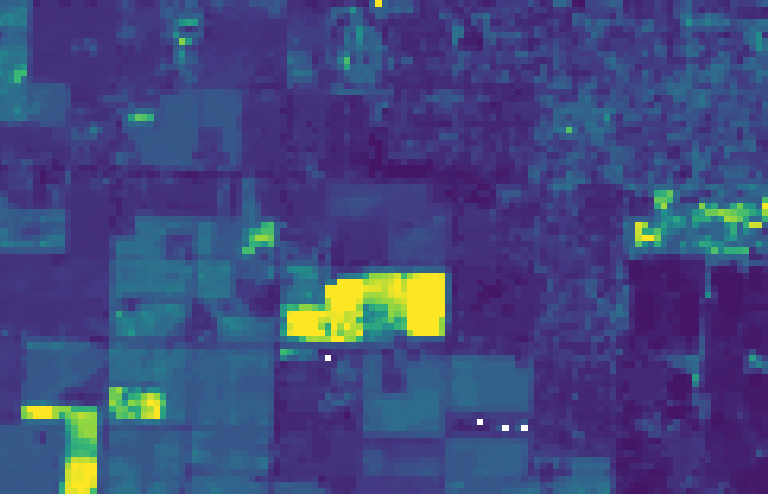

In [7]:
# Generate the LAI image
# Right now the input image needs to be unscaled (raw) but renamed
output_img = openet.lai.landsat.getLAIImage(
    landsat_sr_img.select(input_bands.get(spacecraft_id), output_bands), 
    sensor=landsat_id.split('_')[0], nonveg=True)

# pprint.pprint(landsat_sr_img.select(input_bands.get(spacecraft_id), output_bands).getInfo())
# pprint.pprint(output_img.getInfo())

image_url = output_img.select(['LAI'])\
    .reproject(crs=landsat_crs, scale=30)\
    .getThumbURL({'min': 0, 'max': 4, 'palette': viridis_palette,
                  'dimensions':image_size, 'region': study_region})
Image(url=image_url, embed=True, format='png')


In [8]:
# def point_image_value(image, xy, scale=1):
#     """Extract the output value from a calculation at a point"""
#     return ee.Image(image).reduceRegion(
#         reducer=ee.Reducer.first(), geometry=ee.Geometry.Point(xy),
#         scale=scale).getInfo()

# pprint.pprint(point_image_value(prep_img.select(['tir']), site_xy, scale=1))
# pprint.pprint(point_image_value(output_img.select(['tir_original']), site_xy, scale=1))
# pprint.pprint(point_image_value(output_img.select(['tir_sharpened']), site_xy, scale=1))
